#  Sequence to Sequence Learning



In [1]:
import collections
import math
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

Implement the RNN encoder

In [2]:
class Seq2SeqEncoder(d2l.Module):  
    """The RNN encoder for sequence to sequence learning."""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = d2l.GRU(embed_size, num_hiddens, num_layers, dropout)
    def forward(self, X):
        embs = self.embedding(X.t().type(torch.int64))
        output, state = self.rnn(embs)
        return output, state

Illustrate the above encoder implementation

In [3]:
vocab_size, embed_size, num_hiddens, num_layers = 10, 8, 16, 2
batch_size, num_steps = 4, 7

encoder = Seq2SeqEncoder(vocab_size, embed_size, num_hiddens, num_layers)
X = torch.zeros((batch_size, num_steps))
outputs, state = encoder(X)

d2l.check_shape(outputs, (num_steps, batch_size, num_hiddens))
d2l.check_shape(state, (num_layers, batch_size, num_hiddens))

Decoder

In [4]:
class Seq2SeqDecoder(d2l.Module):
    """The RNN decoder for sequence to sequence learning."""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0):
        super(Seq2SeqDecoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = d2l.GRU(embed_size + num_hiddens, num_hiddens, num_layers, dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)
    def forward(self, X, enc_state, state=None):
        embs = self.embedding(X.t().type(torch.int32))
        context = enc_state[-1]
        context = context.repeat(embs.shape[0], 1, 1)
        embs_and_context = torch.cat((embs, context), -1)
        outputs, state = self.rnn(embs_and_context, state)
        outputs = self.dense(outputs).swapaxes(0, 1)
        return outputs, state

Illustrate the implemented decoder

In [6]:
decoder = Seq2SeqDecoder(vocab_size, embed_size, num_hiddens, num_layers)
outputs, state = decoder(X, encoder(X)[1])

d2l.check_shape(outputs, (batch_size, num_steps, vocab_size))
d2l.check_shape(state, (num_layers, batch_size, num_hiddens))

class Seq2Seq(d2l.Classification):  
    def __init__(self, encoder, decoder, tgt_pad, lr):
        super().__init__()
        self.save_hyperparameters()

    def forward(self, src, tgt):
        return self.decoder(tgt, self.encoder(src)[1])[0]

Mask irrelevant entries with zero values

In [7]:
@d2l.add_to_class(Seq2Seq)
def loss(self, Y_hat, Y):
    l = super(Seq2Seq, self).loss(Y_hat, Y, averaged=False)
    mask = (Y.reshape(-1) != self.tgt_pad).type(torch.float32)
    return (l * mask).sum() / mask.sum()

Training

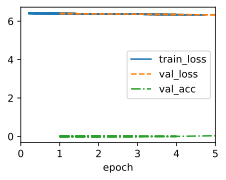

In [9]:
@d2l.add_to_class(Seq2Seq)
def accuracy(self, X, Y):
    acc = super(Seq2Seq, self).accuracy(X, Y, averaged=False)
    mask = (Y.reshape(-1) != self.tgt_pad).type(torch.float32)
    return (acc * mask).sum() / mask.sum()

data = d2l.MTFraEng(batch_size=64, num_steps=10)
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
encoder = Seq2SeqEncoder(
    len(data.src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqDecoder(
    len(data.tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
model = Seq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'], lr=0.005)
trainer = d2l.Trainer(max_epochs=5, gradient_clip_val=1)
trainer.fit(model, data)

Create and train an RNN encoder-decoder model
Prediction

In [11]:
@d2l.add_to_class(Seq2Seq)  
def predict_step(self, batch):
    src, tgt, _ = batch
    enc_state = self.encoder(src)[1]
    dec_state = None
    outputs = [tgt[:, (0)].unsqueeze(1), ]
    for _ in range(tgt.shape[1]):
        Y, dec_state = self.decoder(outputs[-1], enc_state, dec_state)
        outputs.append(Y.argmax(2))
    return torch.cat(outputs[1:], 1)

batch = data.build(["hi !"], [""])
data.tgt_vocab.to_tokens(model.predict_step(batch)[0])

['rentrez', 'voté', 'voté', 'voté', 'voté', 'voté', 'voté', 'arrête', 'arrête']

Implement the BLEU measure

In [12]:
def bleu(pred_seq, label_seq, k):  
    """Compute the BLEU."""
    pred_tokens, label_tokens = pred_seq.split(' '), label_seq.split(' ')
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    score = math.exp(min(0, 1 - len_label / len_pred))
    for n in range(1, k + 1):
        num_matches, label_subs = 0, collections.defaultdict(int)
        for i in range(len_label - n + 1):
            label_subs[''.join(label_tokens[i: i + n])] += 1
        for i in range(len_pred - n + 1):
            if label_subs[''.join(pred_tokens[i: i + n])] > 0:
                num_matches += 1
                label_subs[''.join(pred_tokens[i: i + n])] -= 1
        score *= math.pow(num_matches / (len_pred - n + 1), math.pow(0.5, n))
    return score

Translate a few English sentences into French

In [13]:
engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
batch = data.build(engs, fras)
preds = model.predict_step(batch)
for en, fr, p in zip(engs, fras, preds):
    translation = []
    for token in data.tgt_vocab.to_tokens(p):
        if token == '<eos>': break
        translation.append(token)
    print(f'{en} => {translation}')#, bleu {bleu(" ".join(translation), fr, k=2):.3f}')

go . => ['rentrez', 'voté', 'voté', 'voté', 'voté', 'voté', 'voté', 'arrête', 'arrête']
i lost . => ['rentrez', 'voté', 'voté', 'voté', 'voté', 'voté', 'voté', 'arrête', 'arrête']
he's calm . => ['rentrez', 'voté', 'voté', 'voté', 'voté', 'voté', 'voté', 'voté', 'arrête']
i'm home . => ['rentrez', 'voté', 'voté', 'voté', 'voté', 'voté', 'voté', 'arrête', 'arrête']
